# **Clicks removal**



In this project, I worked on dataset composed of two kinds of audios :
  - voixref : audios of 10 secondes 
  - voixclicks : sames audios as voixref but with clicks (as noise).

The project is an inpainting problem that seeks to remove the clicks in the audios. To do so, I have tried two approaches:

- WAVE-U-NET architecture [https://arxiv.org/pdf/1806.03185.pdf].
- U-NET architecture on spectrograms amplitude, then reconstruct the audio from the predicted spectrogram amplitude using griffinlim library.

## **Import Packages**

In [ ]:
!pip install pesq

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pylab as plt 
import scipy
import librosa 
import librosa.display
import IPython.display as ipd
from sklearn.metrics import precision_score, recall_score
import os
from pesq import pesq
from tqdm import tqdm
import time
import torch
import torch.nn as nn
import random
from scipy.signal import medfilt

## **Data Processing**

In [ ]:
TRAIN_PATH = "/kaggle/input/data-clicks/voixref_train/train/"
TRAIN_CLICKS_PATH = "/kaggle/input/data-clicks/voixclicks_train/train/"
TEST_PATH = "/kaggle/input/data-clicks/voixref_test/test/"
TEST_CLICKS_PATH = "/kaggle/input/data-clicks/voixclicks_test/test/"

In [ ]:
def get_signals(path):
    """
    A function that browses the path of files  and returns the signals
    path : the path of the signals
    return : the signals inside the directory
    """
    signals = []
    start = time.time()
    for r, d, f in os.walk(path):
        for file in f:
            if file.endswith(".wav"):
                signal, sr = librosa.load(path + file, sr = None)
                signals.append(signal)
    end = time.time()
    print(f"The data is imported in {end - start} seconds")
    return signals

In [ ]:
signals = get_signals(TRAIN_PATH)
signals_clicks = get_signals(TRAIN_CLICKS_PATH)
signals_test = get_signals(TEST_PATH)
signals_clicks_test = get_signals(TEST_CLICKS_PATH)

The data is imported in 37.27773952484131 seconds
The data is imported in 39.433279275894165 seconds
The data is imported in 12.71916651725769 seconds
The data is imported in 14.130028486251831 seconds


## Let's hear some audios

## Training audios :

### Without clicks :

In [ ]:
num = random.randint(0, len(signals))
#Forme d'onde temporelle du signal audio
y = signals[num]
ipd.Audio(data = y, rate = 8000)

### With clicks

In [ ]:
num = random.randint(0, len(signals_clicks))
#Forme d'onde temporelle du signal audio
y = signals_clicks[num]
ipd.Audio(data = y, rate = 8000)

## Test audios :

### Without clicks :

In [ ]:
num = random.randint(0, len(signals_test))
#Forme d'onde temporelle du signal audio
y = signals_test[num]
ipd.Audio(data = y, rate = 8000)

### With clicks

In [ ]:
num = random.randint(0, len(signals_clicks_test))
#Forme d'onde temporelle du signal audio
y = signals_clicks_test[num]
ipd.Audio(data = y, rate = 8000)

## **Deep Learning for clicks removal**

## Build a dataset

In [ ]:
class AudioDataset(torch.utils.data.Dataset):
    def __init__(self, clicks_data, ref_data):
        self.clicks_data = clicks_data
        self.ref_data = ref_data

    def __len__(self):
        return len(self.ref_data)

    def __getitem__(self, idx):
        clicks = self.clicks_data[idx]
        ref = self.ref_data[idx]
        return clicks, ref

In [ ]:
# Create the dataset
train_dataset = AudioDataset(signals_clicks, signals)
test_dataset = AudioDataset(signals_clicks_test, signals_test)

## Build dataloaders

In [ ]:
# Create dataloader
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True)

### This part consists of trying the UNET architecture on the temporal data 

## **Architecture**

In [ ]:
import torch
import torch.nn as nn

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(EncoderBlock, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding="same")
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, padding="same")
        self.pool = nn.MaxPool1d(kernel_size=2)
        

    def forward(self, x):
        #print(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        p = self.pool(x)
        return x, p

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(DecoderBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding = "same"),
            nn.ReLU(),
            nn.Conv1d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, padding = "same"),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=out_channels, out_channels=out_channels, kernel_size=2, stride=2)
        )
        self.conv = nn.Conv1d(in_channels=out_channels*2, out_channels=out_channels, kernel_size=kernel_size, padding = "same")
        self.relu = nn.ReLU()
        
    def forward(self, x, skip):
        x = self.block(x)
        #Handle the case where the output of the decoder has different shape with the encoder
        if x.shape != skip.shape:
            zero_tensor = torch.zeros((x.shape[0], x.shape[1], 1)).to(device)
            # Concatenate the original tensor with the tensor of 0s along the last dimension
            x = torch.cat((x, zero_tensor), dim=2)
          
        #Concatenate the residue of the encoder with the decoder
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        x = self.relu(x)
        return x

In [ ]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, input_size, num_filters, kernel_size):
        super(UNet, self).__init__()

        # Define the encoder part using the EncoderBlock subclass
        self.encoder1 = EncoderBlock(input_size, num_filters, kernel_size)
        self.encoder2 = EncoderBlock(num_filters, num_filters*2, kernel_size)
        self.encoder3 = EncoderBlock(num_filters*2, num_filters*4, kernel_size)
        self.encoder4 = EncoderBlock(num_filters*4, num_filters*8, kernel_size)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv1d(in_channels=num_filters*8, out_channels=num_filters*8, kernel_size=kernel_size, padding = "same"),
            nn.ReLU()
        )

        # Define the decoder part using the DecoderBlock subclass
        self.decoder1 = DecoderBlock(num_filters*8, num_filters*8, kernel_size)
        self.decoder2 = DecoderBlock(num_filters*8, num_filters*4, kernel_size)
        self.decoder3 = DecoderBlock(num_filters*4, num_filters*2, kernel_size)
        self.decoder4 = DecoderBlock(num_filters*2, num_filters, kernel_size)

        # Output layer
        self.output = nn.Sequential(
            nn.Conv1d(in_channels=num_filters, out_channels=num_filters, kernel_size=kernel_size, padding = "same"),
            nn.ReLU(),
            nn.Conv1d(in_channels=num_filters, out_channels=input_size, kernel_size=kernel_size, padding = "same"),
            nn.LeakyReLU()
        )

    def forward(self, x):
        # Encoder part
        x1, p1 = self.encoder1(x)
        x2, p2 = self.encoder2(p1)
        x3, p3 = self.encoder3(p2)
        x4, p4 = self.encoder4(p3)

        # Bottleneck
        x = self.bottleneck(p4)
        
        # Decoder part
        x = self.decoder1(x, x4)
        x = self.decoder2(x, x3)
        x = self.decoder3(x, x2)
        x = self.decoder4(x, x1)

        # Output layer
        x = self.output(x)

        return x

In [ ]:
if torch.cuda.is_available():
    # If a GPU is available, set the device to GPU
    device = torch.device("cuda")
else:
    # If a GPU is not available, set the device to CPU
    device = torch.device("cpu")

# Print the device that will be used
print(f"Device: {device}")

Device: cuda


In [ ]:
model = UNet(input_size=1, num_filters=16, kernel_size=2)
model = nn.DataParallel(model)
model = model.to(device)

## **Training and validation of the model**

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 40

In [ ]:
def train_validate(model, train_loader, val_loader, optimizer, criterion, num_epochs):
    """
    A function that trains the model and validate on the validation dataset
    """

    loss_train, loss_val = 0, 0
    pesq_train, pesq_val = 0, 0
    train_losses, val_losses = [], []

    for idx, epoch in enumerate(range(num_epochs)):
        #Trining part

        # Set the model to training mode
        model.train()
        
        # Loop over the training data
        for x, y in tqdm(train_loader):
            
            # Move the data to the correct device
            x = x.unsqueeze(1).to(device)
            y = y.unsqueeze(1).to(device)
            
            # Zero out the gradients
            optimizer.zero_grad()
            
            # Forward pass
            y_pred = model(x)
            
            # Compute the loss
            loss = criterion(y_pred, y)
            loss_train += loss.item()
            
            # Backward pass
            loss.backward()
            optimizer.step()
        
        #Validation part
        model.eval()
        for x, y in tqdm(val_loader):
            # Forward pass
            x = x.unsqueeze(1).to(device)
            y = y.unsqueeze(1).to(device)
            
            y_pred = model(x)
            # Calculate the loss
            v_loss = criterion(y_pred, y)
            loss_val += v_loss.item()
        
        print(f" epoch {idx} ==> Training loss : {loss_train / len(train_loader.dataset)}  |  Validation loss : {loss_val / len(val_loader.dataset)}")
        
        train_losses.append(loss_train / len(train_loader.dataset))
        val_losses.append(loss_val / len(val_loader.dataset))
        loss_train, loss_val = 0, 0
        
    return train_losses, val_losses

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
train_losses, val_losses = train_validate(model, train_dataloader, test_dataloader, optimizer, criterion, num_epochs)

  0%|          | 0/133 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/modules/conv.py:299: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/native/Convolution.cpp:743.)
  self.padding, self.dilation, self.groups)
100%|██████████| 49/49 [00:03<00:00, 16.17it/s]


 epoch 0 ==> Training loss : 0.00023021648560560065  |  Validation loss : 0.0002229602640027852


100%|██████████| 49/49 [00:03<00:00, 16.14it/s]


 epoch 1 ==> Training loss : 0.00018520982343724616  |  Validation loss : 0.0002047065422153267


100%|██████████| 49/49 [00:03<00:00, 16.00it/s]


 epoch 2 ==> Training loss : 0.00017890848918106474  |  Validation loss : 0.00020015448727228147


100%|██████████| 49/49 [00:03<00:00, 15.76it/s]


 epoch 3 ==> Training loss : 0.0001269926847061151  |  Validation loss : 7.538599110401385e-05


100%|██████████| 49/49 [00:03<00:00, 14.74it/s]


 epoch 4 ==> Training loss : 6.778835995818424e-05  |  Validation loss : 7.252677512305129e-05


100%|██████████| 49/49 [00:03<00:00, 15.71it/s]


 epoch 5 ==> Training loss : 6.514239208280295e-05  |  Validation loss : 6.930424106519317e-05


100%|██████████| 49/49 [00:03<00:00, 15.80it/s]


 epoch 6 ==> Training loss : 6.435832843194144e-05  |  Validation loss : 6.731536813721041e-05


100%|██████████| 49/49 [00:03<00:00, 15.47it/s]


 epoch 7 ==> Training loss : 6.383030005441354e-05  |  Validation loss : 6.69592366222759e-05


100%|██████████| 49/49 [00:03<00:00, 15.30it/s]


 epoch 8 ==> Training loss : 6.317618008719703e-05  |  Validation loss : 7.244846802931327e-05


100%|██████████| 49/49 [00:03<00:00, 15.66it/s]


 epoch 9 ==> Training loss : 6.29051770079209e-05  |  Validation loss : 6.681813946579728e-05


100%|██████████| 49/49 [00:03<00:00, 15.71it/s]


 epoch 10 ==> Training loss : 6.317195178706962e-05  |  Validation loss : 6.593994113266507e-05


100%|██████████| 49/49 [00:03<00:00, 15.71it/s]


 epoch 11 ==> Training loss : 6.260699007156234e-05  |  Validation loss : 6.744445560921622e-05


100%|██████████| 49/49 [00:03<00:00, 15.69it/s]


 epoch 12 ==> Training loss : 6.244366363480658e-05  |  Validation loss : 6.803301277051173e-05


100%|██████████| 49/49 [00:03<00:00, 14.71it/s]


 epoch 13 ==> Training loss : 6.25480180434756e-05  |  Validation loss : 6.836616506209344e-05


100%|██████████| 49/49 [00:03<00:00, 15.67it/s]


 epoch 14 ==> Training loss : 6.240190087480786e-05  |  Validation loss : 6.499118454482816e-05


100%|██████████| 49/49 [00:03<00:00, 15.76it/s]


 epoch 15 ==> Training loss : 6.15001031330842e-05  |  Validation loss : 6.692944888902061e-05


100%|██████████| 49/49 [00:03<00:00, 15.72it/s]


 epoch 16 ==> Training loss : 6.170491041568116e-05  |  Validation loss : 6.511737108695062e-05


100%|██████████| 49/49 [00:03<00:00, 15.30it/s]


 epoch 17 ==> Training loss : 6.140387982347271e-05  |  Validation loss : 6.540844854398552e-05


100%|██████████| 49/49 [00:03<00:00, 15.81it/s]


 epoch 18 ==> Training loss : 6.136572868668767e-05  |  Validation loss : 6.776691265249401e-05


100%|██████████| 49/49 [00:03<00:00, 15.77it/s]


 epoch 19 ==> Training loss : 6.05986254235661e-05  |  Validation loss : 6.651144940406084e-05


100%|██████████| 49/49 [00:03<00:00, 15.86it/s]


 epoch 20 ==> Training loss : 6.173528926323913e-05  |  Validation loss : 6.892067796188643e-05


100%|██████████| 49/49 [00:03<00:00, 14.94it/s]


 epoch 21 ==> Training loss : 6.049435222530219e-05  |  Validation loss : 6.515045849489682e-05


100%|██████████| 49/49 [00:03<00:00, 14.56it/s]


 epoch 22 ==> Training loss : 6.0506910486920714e-05  |  Validation loss : 6.395064013274124e-05


100%|██████████| 49/49 [00:03<00:00, 15.77it/s]


 epoch 23 ==> Training loss : 6.045756773184193e-05  |  Validation loss : 6.617757852327392e-05


100%|██████████| 49/49 [00:03<00:00, 15.77it/s]


 epoch 24 ==> Training loss : 5.965636140267638e-05  |  Validation loss : 6.372981135795355e-05


100%|██████████| 49/49 [00:03<00:00, 15.73it/s]


 epoch 25 ==> Training loss : 6.05695001568603e-05  |  Validation loss : 6.288364517700184e-05


100%|██████████| 49/49 [00:03<00:00, 15.33it/s]


 epoch 26 ==> Training loss : 5.972577205958501e-05  |  Validation loss : 6.309309115340394e-05


100%|██████████| 49/49 [00:03<00:00, 15.73it/s]


 epoch 27 ==> Training loss : 5.94537288550291e-05  |  Validation loss : 6.214101747323847e-05


100%|██████████| 49/49 [00:03<00:00, 15.76it/s]


 epoch 28 ==> Training loss : 5.834957597270693e-05  |  Validation loss : 6.15255377800835e-05


100%|██████████| 49/49 [00:03<00:00, 15.74it/s]


 epoch 29 ==> Training loss : 5.9615026213399314e-05  |  Validation loss : 6.547645169079228e-05


100%|██████████| 49/49 [00:03<00:00, 15.71it/s]


 epoch 30 ==> Training loss : 5.875207318104733e-05  |  Validation loss : 6.174807139920056e-05


100%|██████████| 49/49 [00:03<00:00, 14.42it/s]


 epoch 31 ==> Training loss : 5.850587876749289e-05  |  Validation loss : 6.262425166826285e-05


100%|██████████| 49/49 [00:03<00:00, 15.74it/s]


 epoch 32 ==> Training loss : 5.828164831948017e-05  |  Validation loss : 6.317714502549042e-05


100%|██████████| 49/49 [00:03<00:00, 15.78it/s]


 epoch 33 ==> Training loss : 5.735843884296947e-05  |  Validation loss : 6.078912593993594e-05


100%|██████████| 49/49 [00:03<00:00, 15.72it/s]


 epoch 34 ==> Training loss : 5.718005349621268e-05  |  Validation loss : 6.151725532120222e-05


100%|██████████| 49/49 [00:03<00:00, 15.35it/s]


 epoch 35 ==> Training loss : 5.71519543112953e-05  |  Validation loss : 6.119754966920065e-05


100%|██████████| 49/49 [00:03<00:00, 15.75it/s]


 epoch 36 ==> Training loss : 5.681031552095906e-05  |  Validation loss : 6.022156961143131e-05


100%|██████████| 49/49 [00:03<00:00, 15.76it/s]


 epoch 37 ==> Training loss : 5.638561126550904e-05  |  Validation loss : 6.027165596382907e-05


100%|██████████| 49/49 [00:03<00:00, 15.82it/s]


 epoch 38 ==> Training loss : 5.6391183206217045e-05  |  Validation loss : 6.108973151468255e-05


100%|██████████| 49/49 [00:03<00:00, 15.75it/s]

 epoch 39 ==> Training loss : 5.614164597451567e-05  |  Validation loss : 6.274388538247161e-05


### Let's plot the losses 

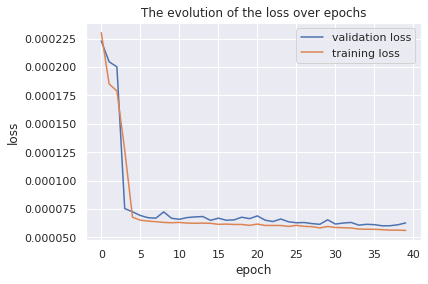

In [ ]:
import seaborn as sns
sns.set_theme()
plt.plot(val_losses, label='validation loss')
plt.plot(train_losses, label='training loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("The evolution of the loss over epochs")
plt.show()

### Let's compute the overall performance of the model

#### To compute the performance of the model we will use PSEQ (Perceptual Evaluation of Sound Quality)

In [ ]:
pesq_val = []
bad, meduim, best = [], [], []
for x, y in tqdm(test_dataloader):
    # Forward pass
    x = x.unsqueeze(1).to(device)
    y = y.unsqueeze(1).to(device)

    y_pred = model(x)
    for ref, pred in zip(y, y_pred):
        score = pesq(8000, ref.cpu()[0].detach().numpy(), pred.cpu()[0].detach().numpy(), 'nb')
        
        #Save an audio that is in one of the following scores
        if score >= 1 and score < 2 and not bad: # ==>  impossible de comprendre
            bad.append((y, y_pred))
        
        elif score >= 2.4 and score < 2.8 and not meduim: # ==> effort modéré pour comprendre
            meduim.append((y, y_pred))
        
        elif score >= 3.3 and score < 4.5 and not best: # ==> attention nécessaire | aucun effort requis
            best.append((y, y_pred))
            
        pesq_val.append(score)

100%|██████████| 49/49 [01:26<00:00,  1.76s/it]


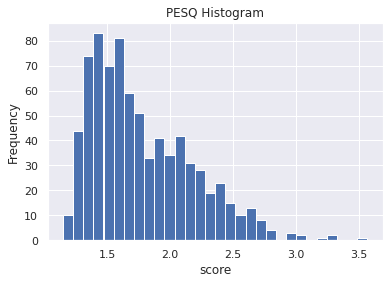

In [ ]:
#Plot the distribution of the scores
plt.hist(pesq_val, bins=30)

# Add labels and title
plt.xlabel('score')
plt.ylabel('Frequency')
plt.title('PESQ Histogram')
plt.show()

In [ ]:
print(f"The mean pesq score over the test dataset is {round(np.mean(pesq_val), 4)}")

The mean pesq score over the test dataset is 1.7789


## best example 

### original

In [ ]:
ipd.Audio(data = best[0][0].cpu()[0].detach().numpy(), rate = 8000)

### predicted

In [ ]:
ipd.Audio(data = best[0][1].cpu()[0].detach().numpy(), rate = 8000)

## meduim

### original

In [ ]:
ipd.Audio(data = meduim[0][0].cpu()[0].detach().numpy(), rate = 8000)

### predicted

In [ ]:
ipd.Audio(data = meduim[0][1].cpu()[0].detach().numpy(), rate = 8000)

## bad

### original

In [ ]:
ipd.Audio(data = bad[0][0].cpu()[0].detach().numpy(), rate = 8000)

### predicted

In [ ]:
ipd.Audio(data = bad[0][1].cpu()[0].detach().numpy(), rate = 8000)

# **2nd approach : why not operating on Spectrograms ?**

In [ ]:
# Spectrogram parameters
nperseg = 256
nfft = 1024
noverlap = 128
sr = 8000

## Let's visualize some examples

In [ ]:
def get_spectrogram(audio):
    """
    A function that returns the spectrogram amplitude of an audio
    """
    f, t, Zxx = scipy.signal.stft(audio, sr, nperseg = nperseg, nfft = nfft, noverlap = noverlap)
    amplitude = librosa.amplitude_to_db(np.abs(Zxx), ref=np.max)
    return amplitude

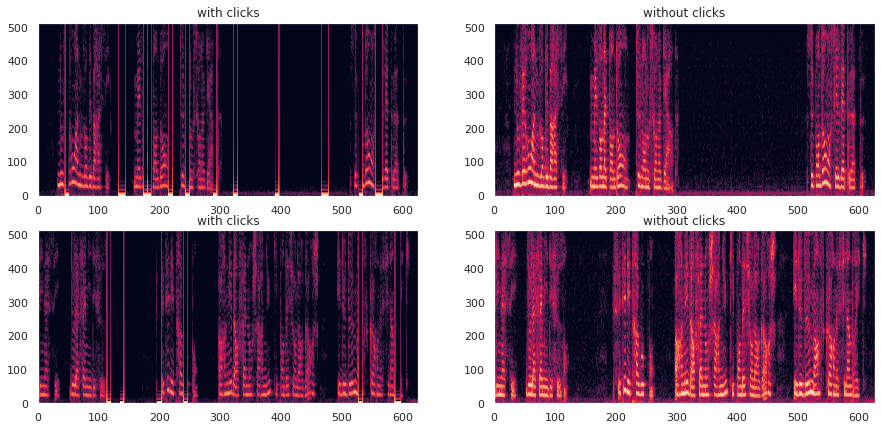

In [ ]:
#Plot two random examples (with and without clicks)
fig, axs = plt.subplots(2, 2, figsize=(15, 7))
idx = 0
for click, no_click in zip(signals_clicks, signals):
    if idx == 2:
        break
    s_click, s_no_click = get_spectrogram(click), get_spectrogram(no_click)
    
    axs[idx, 0].pcolormesh(s_click)
    axs[idx, 0].set_title("with clicks")
    
    axs[idx, 1].pcolormesh(s_no_click)
    axs[idx, 1].set_title("without clicks")
    idx += 1
    

## Let's create dataloaders of spectrograms 

In [ ]:
def create_data_spectrogram(data):
    """
    A function that stacks spectrograms in a list
    """
    spec = []
    for audio in data:
        spec.append(get_spectrogram(audio))
    return spec

In [ ]:
#Trainging reference
spec_train_ref = create_data_spectrogram(signals)
# Training with clicks
spec_train_clicks = create_data_spectrogram(signals_clicks)
#Test reference
spec_val_ref = create_data_spectrogram(signals_test)
#Test with clicks
spec_val_clicks = create_data_spectrogram(signals_clicks_test)

In [ ]:
# Create the dataset
train_dataset = AudioDataset(spec_train_clicks, spec_train_ref)
# Create the dataset
val_dataset = AudioDataset(spec_val_clicks, spec_val_ref)

In [ ]:
# Create the dataloader
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=True)

## **UNET on STFT**

In [ ]:
import torch
import torch.nn as nn

class EncoderBlock1(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(EncoderBlock1, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding="same")
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, padding="same")
        self.pool = nn.MaxPool2d(kernel_size=kernel_size)
        

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        p = self.pool(x)
        return x, p

class DecoderBlock1(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(DecoderBlock1, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding = "same"),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, padding = "same"),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, stride=kernel_size)
        )
        self.conv = nn.Conv2d(in_channels=out_channels*2, out_channels=out_channels, kernel_size=kernel_size, padding = "same")
        self.relu = nn.ReLU()
        
    def forward(self, x, skip):
        x = self.block(x)
        
        if x.shape != skip.shape:
            if x.shape[2] != skip.shape[2]:
                zero_tensor = torch.zeros((x.shape[0], x.shape[1], 1, x.shape[3])).to(device)
                # Concatenate the original tensor with the tensor of 0s along the 3rd dimension
                x = torch.cat((x, zero_tensor), dim=2)
            else:
                zero_tensor = torch.zeros((x.shape[0], x.shape[1], x.shape[2], 1)).to(device)
                # Concatenate the original tensor with the tensor of 0s along the last dimension
                x = torch.cat((x, zero_tensor), dim=3)
                
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        x = self.relu(x)
       
        return x

In [ ]:
import torch
import torch.nn as nn

class UNet1(nn.Module):
    def __init__(self, input_size, num_filters, kernel_size):
        super(UNet1, self).__init__()

        # Define the encoder part using the EncoderBlock subclass
        self.encoder1 = EncoderBlock1(input_size, num_filters, kernel_size)
        self.encoder2 = EncoderBlock1(num_filters, num_filters*2, kernel_size)
        self.encoder3 = EncoderBlock1(num_filters*2, num_filters*4, kernel_size)
        self.encoder4 = EncoderBlock1(num_filters*4, num_filters*8, kernel_size)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(in_channels=num_filters*8, out_channels=num_filters*8, kernel_size=kernel_size, padding = "same"),
            nn.ReLU()
        )

        # Define the decoder part using the DecoderBlock subclass
        self.decoder1 = DecoderBlock1(num_filters*8, num_filters*8, kernel_size)
        self.decoder2 = DecoderBlock1(num_filters*8, num_filters*4, kernel_size)
        self.decoder3 = DecoderBlock1(num_filters*4, num_filters*2, kernel_size)
        self.decoder4 = DecoderBlock1(num_filters*2, num_filters, kernel_size)

        # Output layer
        self.output = nn.Sequential(
            nn.Conv2d(in_channels=num_filters, out_channels=num_filters, kernel_size=kernel_size, padding = "same"),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_filters, out_channels=input_size, kernel_size=kernel_size, padding = "same"),
            nn.LeakyReLU()
        )

    def forward(self, x):
        # Encoder part
        x1, p1 = self.encoder1(x)
        x2, p2 = self.encoder2(p1)
        x3, p3 = self.encoder3(p2)
        x4, p4 = self.encoder4(p3)

        # Bottleneck
        #x = self.bottleneck(p4)
        
        # Decoder part
        x = self.decoder1(p4, x4)
        x = self.decoder2(x, x3)
        x = self.decoder3(x, x2)
        x = self.decoder4(x, x1)

        # Output layer
        x = self.output(x)

        return x

In [ ]:
from tqdm import tqdm

In [ ]:
EXPERIMENT = "./experiment"
if not os.path.isdir(EXPERIMENT):
    os.makedirs(EXPERIMENT)

In [ ]:
def train_validate1(model, train_loader, val_loader, optimizer, criterion, num_epochs):
    """
    A function that trains the UNET model on the spectrograms and validates on the val dataset
    """
    loss_train, loss_val = 0, 0
    train_losses, val_losses = [], []
    
    for idx, epoch in enumerate(range(num_epochs)):
        # Set the model to training mode
        model.train()
        
        # Loop over the training data
        for x, y in tqdm(train_loader):
            # Move the data to the correct device
            x = x.unsqueeze(1).to(device)
            y = y.unsqueeze(1).to(device)

            # Zero out the gradients
            optimizer.zero_grad()
            
            # Forward pass
            y_pred = model(x)
            
            # Compute the loss
            loss = criterion(y_pred, y)
            loss_train += loss.item()

            
            # Backward pass
            loss.backward()
            optimizer.step()
        
        model.eval()
        for x, y in tqdm(val_loader):
            # Forward pass
            x = x.unsqueeze(1).to(device)
            y = y.unsqueeze(1).to(device)
            
            y_pred = model(x)
            # Calculate the loss
            v_loss = criterion(y_pred, y)
            loss_val += v_loss.item()
            

        model_file = EXPERIMENT + '/model_' + str(epoch) + '.pth'
        torch.save(model.state_dict(), model_file)
        
        print(f" epoch {idx} ==> Training loss : {loss_train / len(train_loader.dataset)}  |  Validation loss : {loss_val / len(val_loader.dataset)} ")
        
        train_losses.append(loss_train / len(train_loader.dataset))
        val_losses.append(loss_val / len(val_loader.dataset))
        loss_train, loss_val = 0, 0
            
    return train_losses, val_losses
        


In [ ]:
#Initialize the model
model1 = UNet1(input_size=1, num_filters=16, kernel_size=(2, 2))
#Put the model on the GPU in a parallel way
model1 = nn.DataParallel(model1)
model1 = model1.to(device)

In [ ]:
# MSE loss as criterion
criterion = nn.MSELoss()
# Adam for optimization
optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)
num_epochs = 60

In [ ]:
train_losses1, val_losses1 = train_validate1(model1, train_dataloader, val_dataloader, optimizer, criterion, num_epochs)

100%|██████████| 98/98 [00:07<00:00, 12.34it/s]


 epoch 0 ==> Training loss : 86.34080217917986  |  Validation loss : 20.71616049373851 


100%|██████████| 98/98 [00:08<00:00, 12.20it/s]


 epoch 1 ==> Training loss : 15.145687733651108  |  Validation loss : 11.394088393891863 


100%|██████████| 98/98 [00:07<00:00, 12.68it/s]


 epoch 2 ==> Training loss : 10.338257606801726  |  Validation loss : 9.426760929624749 


100%|██████████| 98/98 [00:07<00:00, 12.82it/s]


 epoch 3 ==> Training loss : 9.023210957773008  |  Validation loss : 8.335555527826099 


100%|██████████| 98/98 [00:07<00:00, 12.64it/s]


 epoch 4 ==> Training loss : 8.314345240030118  |  Validation loss : 7.575032441512398 


100%|██████████| 98/98 [00:07<00:00, 12.49it/s]


 epoch 5 ==> Training loss : 7.522614022489986  |  Validation loss : 7.127104547017676 


100%|██████████| 98/98 [00:08<00:00, 12.23it/s]


 epoch 6 ==> Training loss : 6.995681735679043  |  Validation loss : 6.62286967206794 


100%|██████████| 98/98 [00:07<00:00, 12.59it/s]


 epoch 7 ==> Training loss : 6.616473948088764  |  Validation loss : 6.261918285008892 


100%|██████████| 98/98 [00:07<00:00, 12.27it/s]


 epoch 8 ==> Training loss : 6.2864845391148325  |  Validation loss : 6.040704980835585 


100%|██████████| 98/98 [00:07<00:00, 12.67it/s]


 epoch 9 ==> Training loss : 6.106324627221587  |  Validation loss : 5.7860394694921 


100%|██████████| 98/98 [00:07<00:00, 12.95it/s]


 epoch 10 ==> Training loss : 5.932986431464032  |  Validation loss : 5.909583362472027 


100%|██████████| 98/98 [00:07<00:00, 12.41it/s]


 epoch 11 ==> Training loss : 5.727101083742886  |  Validation loss : 5.623834097781755 


100%|██████████| 98/98 [00:07<00:00, 12.70it/s]


 epoch 12 ==> Training loss : 5.622407144144867  |  Validation loss : 5.245006592987139 


100%|██████████| 98/98 [00:07<00:00, 12.66it/s]


 epoch 13 ==> Training loss : 5.339401457645175  |  Validation loss : 5.31158670196143 


100%|██████████| 98/98 [00:07<00:00, 12.59it/s]


 epoch 14 ==> Training loss : 5.423686916362125  |  Validation loss : 5.123322967373197 


100%|██████████| 98/98 [00:07<00:00, 12.61it/s]


 epoch 15 ==> Training loss : 5.10268053679786  |  Validation loss : 4.901631630899961 


100%|██████████| 98/98 [00:08<00:00, 12.18it/s]


 epoch 16 ==> Training loss : 5.057987178914157  |  Validation loss : 4.739310079218481 


100%|██████████| 98/98 [00:07<00:00, 12.68it/s]


 epoch 17 ==> Training loss : 4.905452419385469  |  Validation loss : 5.404485075675008 


100%|██████████| 98/98 [00:07<00:00, 12.97it/s]


 epoch 18 ==> Training loss : 4.83717881113544  |  Validation loss : 4.842314571370859 


100%|██████████| 98/98 [00:07<00:00, 12.95it/s]


 epoch 19 ==> Training loss : 4.848154744300446  |  Validation loss : 4.747098617846398 


100%|██████████| 98/98 [00:07<00:00, 12.88it/s]


 epoch 20 ==> Training loss : 4.640573244932353  |  Validation loss : 4.406960621514283 


100%|██████████| 98/98 [00:07<00:00, 12.26it/s]


 epoch 21 ==> Training loss : 4.573729166565806  |  Validation loss : 4.351278983113711 


100%|██████████| 98/98 [00:07<00:00, 12.74it/s]


 epoch 22 ==> Training loss : 4.489028404747348  |  Validation loss : 4.282595092988076 


100%|██████████| 98/98 [00:07<00:00, 12.71it/s]


 epoch 23 ==> Training loss : 4.387445608324549  |  Validation loss : 4.411229353121785 


100%|██████████| 98/98 [00:07<00:00, 12.69it/s]


 epoch 24 ==> Training loss : 4.333520460624082  |  Validation loss : 4.2227515247471805 


100%|██████████| 98/98 [00:07<00:00, 12.69it/s]


 epoch 25 ==> Training loss : 4.333181093052044  |  Validation loss : 4.2416413129138215 


100%|██████████| 98/98 [00:07<00:00, 12.45it/s]


 epoch 26 ==> Training loss : 4.195811228441449  |  Validation loss : 5.0615412865758245 


100%|██████████| 98/98 [00:07<00:00, 12.82it/s]


 epoch 27 ==> Training loss : 4.246884656695401  |  Validation loss : 4.051579270521393 


100%|██████████| 98/98 [00:07<00:00, 12.98it/s]


 epoch 28 ==> Training loss : 4.171542759319878  |  Validation loss : 3.910213521679344 


100%|██████████| 98/98 [00:07<00:00, 12.65it/s]


 epoch 29 ==> Training loss : 4.221045960560511  |  Validation loss : 4.146643314215228 


100%|██████████| 98/98 [00:07<00:00, 12.47it/s]


 epoch 30 ==> Training loss : 4.068271766640985  |  Validation loss : 4.037742768407173 


100%|██████████| 98/98 [00:08<00:00, 12.12it/s]


 epoch 31 ==> Training loss : 3.9616497281140264  |  Validation loss : 4.136308316379557 


100%|██████████| 98/98 [00:07<00:00, 12.68it/s]


 epoch 32 ==> Training loss : 3.96805076491056  |  Validation loss : 3.818885366630066 


100%|██████████| 98/98 [00:07<00:00, 12.69it/s]


 epoch 33 ==> Training loss : 3.8643743309691  |  Validation loss : 3.7789951480563033 


100%|██████████| 98/98 [00:07<00:00, 12.95it/s]


 epoch 34 ==> Training loss : 3.8121538225269407  |  Validation loss : 3.7432429125851683 


100%|██████████| 98/98 [00:07<00:00, 12.76it/s]


 epoch 35 ==> Training loss : 3.814434748533427  |  Validation loss : 3.7146529492819704 


100%|██████████| 98/98 [00:07<00:00, 12.36it/s]


 epoch 36 ==> Training loss : 3.789544548596606  |  Validation loss : 3.961540985595235 


100%|██████████| 98/98 [00:07<00:00, 12.70it/s]


 epoch 37 ==> Training loss : 3.867533457740733  |  Validation loss : 3.6718136306918794 


100%|██████████| 98/98 [00:07<00:00, 12.69it/s]


 epoch 38 ==> Training loss : 3.6629620012638138  |  Validation loss : 3.6264896368431616 


100%|██████████| 98/98 [00:07<00:00, 12.46it/s]


 epoch 39 ==> Training loss : 3.6441912178277294  |  Validation loss : 3.6001920602510653 


100%|██████████| 98/98 [00:07<00:00, 12.70it/s]


 epoch 40 ==> Training loss : 3.674828650030581  |  Validation loss : 3.525941451187329 


100%|██████████| 98/98 [00:08<00:00, 12.23it/s]


 epoch 41 ==> Training loss : 3.627378108030901  |  Validation loss : 3.7832738090963924 


100%|██████████| 98/98 [00:07<00:00, 12.83it/s]


 epoch 42 ==> Training loss : 3.5744894539218  |  Validation loss : 3.7254129639062126 


100%|██████████| 98/98 [00:07<00:00, 12.72it/s]


 epoch 43 ==> Training loss : 3.584647282212269  |  Validation loss : 3.6284569084186993 


100%|██████████| 98/98 [00:07<00:00, 12.93it/s]


 epoch 44 ==> Training loss : 3.5863535964792916  |  Validation loss : 3.4999360745520236 


100%|██████████| 98/98 [00:07<00:00, 12.55it/s]


 epoch 45 ==> Training loss : 3.52027489983664  |  Validation loss : 3.4776356104389787 


100%|██████████| 98/98 [00:08<00:00, 11.99it/s]


 epoch 46 ==> Training loss : 3.5160188242666446  |  Validation loss : 3.4398771856751895 


100%|██████████| 98/98 [00:07<00:00, 12.68it/s]


 epoch 47 ==> Training loss : 3.4576049026618936  |  Validation loss : 3.5249673228739473 


100%|██████████| 98/98 [00:07<00:00, 12.69it/s]


 epoch 48 ==> Training loss : 3.4170000672452963  |  Validation loss : 3.6799935026241997 


100%|██████████| 98/98 [00:07<00:00, 12.71it/s]


 epoch 49 ==> Training loss : 3.4322253633378472  |  Validation loss : 3.48428765221325 


100%|██████████| 98/98 [00:07<00:00, 12.34it/s]


 epoch 50 ==> Training loss : 3.3706822057621335  |  Validation loss : 3.4624872451548074 


100%|██████████| 98/98 [00:07<00:00, 12.48it/s]


 epoch 51 ==> Training loss : 3.3338372966272862  |  Validation loss : 3.5226963901763684 


100%|██████████| 98/98 [00:07<00:00, 12.94it/s]


 epoch 52 ==> Training loss : 3.3404418010549572  |  Validation loss : 3.41450260972123 


100%|██████████| 98/98 [00:07<00:00, 12.70it/s]


 epoch 53 ==> Training loss : 3.4282456795149416  |  Validation loss : 3.509758254146332 


100%|██████████| 98/98 [00:07<00:00, 12.70it/s]


 epoch 54 ==> Training loss : 3.299525021381036  |  Validation loss : 3.354139847523721 


100%|██████████| 98/98 [00:07<00:00, 12.29it/s]


 epoch 55 ==> Training loss : 3.2863712279272033  |  Validation loss : 3.4252702903259746 


100%|██████████| 98/98 [00:07<00:00, 12.29it/s]


 epoch 56 ==> Training loss : 3.265854459984107  |  Validation loss : 3.3507903921024877 


100%|██████████| 98/98 [00:07<00:00, 12.50it/s]


 epoch 57 ==> Training loss : 3.2382629455768126  |  Validation loss : 3.534414242600541 


100%|██████████| 98/98 [00:07<00:00, 12.72it/s]


 epoch 58 ==> Training loss : 3.2288412701081732  |  Validation loss : 3.465283203612813 


100%|██████████| 98/98 [00:07<00:00, 12.93it/s]

 epoch 59 ==> Training loss : 3.2126989229542677  |  Validation loss : 3.3635683425552094 


### Let's plot the losses 

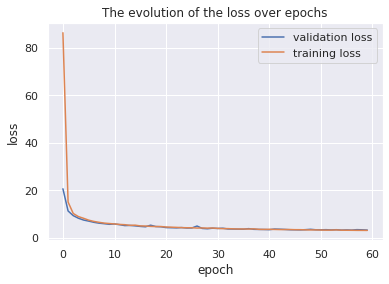

In [ ]:
# Plot the losses 
import seaborn as sns
sns.set_theme()

plt.plot(val_losses1, label='validation loss')
plt.plot(train_losses1, label='training loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("The evolution of the loss over epochs")
plt.show()

In [ ]:
# For preventing "CUDA out of memory"
import gc
gc.collect()
torch.cuda.empty_cache()

## Let's visualize the predicted and the ground truth spectrogram

### Validation dataset 

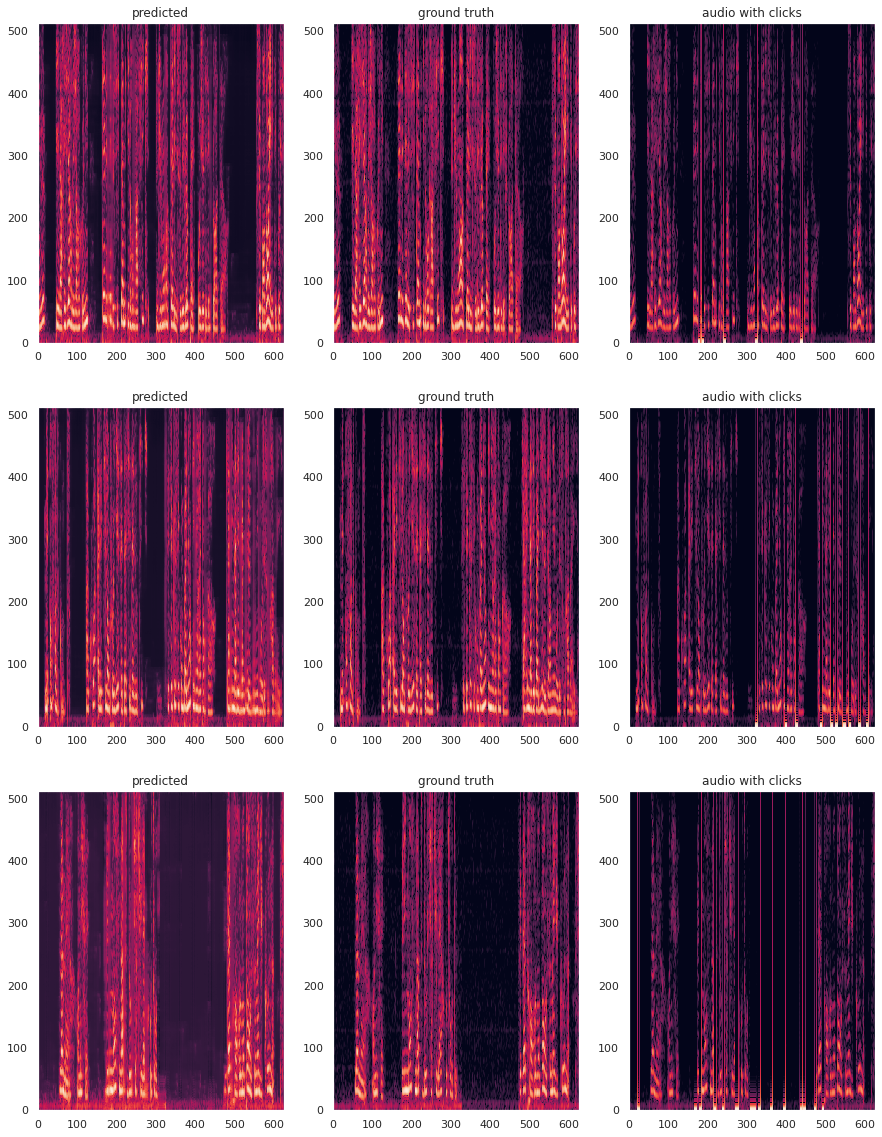

In [ ]:
# Plot the spectrograms of the predicted | reference | click audios

fig, axs = plt.subplots(3, 3, figsize=(15, 20))
ref_val = []
ref_val_click = []
pred_val = []
for idx, batch in zip(range(3), val_dataloader):
    x_val, y_val = batch
    predicted_val = model1(x_val.unsqueeze(1).to(device))
    random_item = random.randint(0, len(x_val) - 1)
    
    pred_val.append(predicted_val[random_item])
    axs[idx, 0].pcolormesh(predicted_val[random_item].to("cpu").detach().numpy()[0])
    axs[idx, 0].set_title("predicted")
    
    ref_val.append(y_val[random_item])
    axs[idx, 1].pcolormesh(y_val[random_item].to("cpu").detach().numpy())
    axs[idx, 1].set_title("ground truth")
    
    ref_val_click.append(x_val[random_item])
    axs[idx, 2].pcolormesh(x_val[random_item].to("cpu").detach().numpy())
    axs[idx, 2].set_title("audio with clicks")

In the previous plots, we can see that the model works quite well. It estimates the values in the places where we have a max of energy (corresponds to the clicks). But we are still can see some noise compared to the reference. In order to see this concretly, let's hear some predicted audios. 

## **Audio reconstruction**

To reconstruct the audios we will use the **griffinlim** library. It takes the amplitude of the scpectrograme and estimates the phase for reconstructing the orginial audio

### Let's check if the griffinlim library works well on original data:

In [ ]:
audio_rec = librosa.griffinlim(librosa.db_to_amplitude(y_train[random_item].to("cpu").detach().numpy()), 
                       n_iter = 200,
                       hop_length =  nperseg - noverlap,
                       win_length = nperseg)
ipd.Audio(data = audio_rec, rate = sr)

In [ ]:
audio_rec = librosa.griffinlim(librosa.db_to_amplitude(predicted_train[random_item].to("cpu").detach().numpy()[0]), 
                       n_iter = 200,
                       hop_length =  nperseg - noverlap,
                       win_length = nperseg)
ipd.Audio(data = audio_rec, rate = sr)

## Check the audio reconstruction on the validation dataset

## **Example 1**:

## Original audio

In [ ]:
audio_orig1 = librosa.griffinlim(librosa.db_to_amplitude(ref_val[0].to("cpu").detach().numpy()), 
                       n_iter = 200,
                       hop_length =  nperseg - noverlap,
                       win_length = nperseg)
ipd.Audio(data = audio_orig1, rate = sr)

## Predicted audio

In [ ]:
audio_pred1 = librosa.griffinlim(librosa.db_to_amplitude(pred_val[0].to("cpu").detach().numpy()[0]), 
                       n_iter = 200,
                       hop_length =  nperseg - noverlap,
                       win_length = nperseg)
ipd.Audio(data = audio_pred1, rate = sr)

## Original with clicks

In [ ]:
audio_click1 = librosa.griffinlim(librosa.db_to_amplitude(ref_val_click[0].to("cpu").detach().numpy()), 
                       n_iter = 200,
                       hop_length =  nperseg - noverlap,
                       win_length = nperseg)
ipd.Audio(data = audio_click1, rate = sr)

### Performance of the constructed audio

In [ ]:
print(f"The PESQ score of the first example is : {pesq(sr, audio_orig1, audio_pred1, 'nb')}")

The PESQ score of the first example is : 3.28094482421875


## **Example 2** 

### Original audio 

In [ ]:
audio_orig2 = librosa.griffinlim(librosa.db_to_amplitude(ref_val[1].to("cpu").detach().numpy()), 
                       n_iter = 200,
                       hop_length =  nperseg - noverlap,
                       win_length = nperseg)
ipd.Audio(data = audio_orig2, rate = sr)

### Predicted audio 

In [ ]:
audio_pred2 = librosa.griffinlim(librosa.db_to_amplitude(pred_val[1].to("cpu").detach().numpy()[0]), 
                       n_iter = 200,
                       hop_length =  nperseg - noverlap,
                       win_length = nperseg)
ipd.Audio(data = audio_pred2, rate = sr)

### Audio with clicks

In [ ]:
audio_click2 = librosa.griffinlim(librosa.db_to_amplitude(ref_val_click[1].to("cpu").detach().numpy()), 
                       n_iter = 200,
                       hop_length =  nperseg - noverlap,
                       win_length = nperseg)
ipd.Audio(data = audio_click2, rate = sr)

In [ ]:
print(f"The PESQ score of the second example is : {pesq(sr, audio_orig2, audio_pred2, 'nb')}")

The PESQ score of the second example is : 2.8747990131378174


## **Example 3** 

### Original audio

In [ ]:
audio_orig3 = librosa.griffinlim(librosa.db_to_amplitude(ref_val[2].to("cpu").detach().numpy()), 
                       n_iter = 200,
                       hop_length =  nperseg - noverlap,
                       win_length = nperseg)
ipd.Audio(data = audio_orig3, rate = sr)

### Predicted audio

In [ ]:
audio_pred3 = librosa.griffinlim(librosa.db_to_amplitude(pred_val[2].to("cpu").detach().numpy()[0]), 
                       n_iter = 200,
                       hop_length =  nperseg - noverlap,
                       win_length = nperseg)
ipd.Audio(data = audio_pred3, rate = sr)

### Audio with clicks

In [ ]:
audio_click3 = librosa.griffinlim(librosa.db_to_amplitude(ref_val_click[2].to("cpu").detach().numpy()), 
                       n_iter = 200,
                       hop_length =  nperseg - noverlap,
                       win_length = nperseg)
ipd.Audio(data = audio_click3, rate = sr)

In [ ]:
print(f"The PESQ score of the third example is : {pesq(sr, audio_orig3, audio_pred3, 'nb')}")

The PESQ score of the third example is : 2.8689353466033936


## **Complexity**

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
## First model on waveform
print(f"The number of parameters of the UNET on the waveform is : {count_parameters(model)}")

The number of parameters of the UNET on the waveform is : 328305


In [ ]:
## Second model on Spectrogram
print(f"The number of parameters of the UNET on the spectrogram is : {count_parameters(model1)}")

The number of parameters of the UNET on the spectrogram is : 655025


In terms of time complexity, the first model is faster than the second since it operates on 1D vector, but the second works on image-like data which is much bigger.
The first model trains in 20s per epoch and the second is almost 50s per epoch

## Future works 

On this project, we have tried two different deep learning based approaches. Both of them are inspired from the UNET architecture, but the first one operates on the waveform of the data and the second works on the spectrograms. Many other methods could be used for this problem :

- Trying different parametrs for the same previous models (number of filters, number of encoder-decoder blocks, number of convolutions inside each block...)
- Trying a model based on a combination of CNN and RNN. 
- Trying different types of autoencoders (for example an RNN backbone for the decoder or the encoder).


